In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd
import numpy as np
import torch
from chronos import BaseChronosPipeline
from tqdm import tqdm
from timeseries import PredictionLeadTime, PredictionLeadTimes
from data_preparation import ChronosBacktestingDataset
from torch.utils.data import DataLoader

In [ ]:
# read in data. Here only using data from 2021-2025 for first tests
df = pd.read_csv("data/Realisierter_Stromverbrauch_202103010000_202503270000_Stunde.csv", thousands=".", decimal=",", sep=";")

# bring data in right shape
for col in df.columns[2:]:
    df[col] = df[col].str.replace('.', '')
    df[col] = df[col].str.replace(',', '.').replace("-",np.nan).astype(float)
df = df[["Datum von", "Netzlast [MWh] Berechnete Auflösungen"]].copy()
df = df.rename(columns={"Datum von":"timestamp", "Netzlast [MWh] Berechnete Auflösungen": "target"})
df["item_id"] = 0 
df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True)
df = df.drop_duplicates(subset=["item_id","timestamp"], keep="first")

In [38]:
df.tail(20)

,timestamp,target,item_id
35668,2025-03-26 04:00:00,46351.50,0
35669,2025-03-26 05:00:00,49857.25,0
35670,2025-03-26 06:00:00,56725.50,0
35671,2025-03-26 07:00:00,60778.00,0
35672,2025-03-26 08:00:00,63646.00,0
35673,2025-03-26 09:00:00,64506.75,0
35674,2025-03-26 10:00:00,65507.25,0
35675,2025-03-26 11:00:00,66186.00,0
35676,2025-03-26 12:00:00,65441.00,0
35677,2025-03-26 13:00:00,64230.50,0


In [19]:
# create TimesSeriesDataFrame
data = TimeSeriesDataFrame.from_data_frame(df)
# prepare data by creating dataloader
ds = ChronosBacktestingDataset(data, context_length=2048)
dl = DataLoader(ds, batch_size=64)

In [20]:
# load model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-tiny", # could also use e.g. "amazon/chronos-bolt-small" or "amazon/chronos-bolt-base".
    device_map="mps", # mps for using mac gpu
)

In [21]:
# make predictions
freq = pd.Timedelta("1h")
prediction_length = 64
lead_times = np.arange(1,prediction_length+1)

results = {ld: None for ld in lead_times}
forecasts = []

for batch in tqdm(dl):
    forecast = pipeline.predict(context=batch, prediction_length=prediction_length)
    forecasts.append(forecast)

forecasts = torch.vstack(forecasts)

for lt in lead_times:
    results[lt] = PredictionLeadTime(lead_time=lt,
                                     predictions=forecasts[..., lt-1],
                                     freq=freq,
                                     data=data)

predictions = PredictionLeadTimes(results=results)

100%|██████████| 558/558 [00:28<00:00, 19.38it/s]


In [ ]:
# calculate crps for all lead times (1 to 64)
predictions.get_crps()

{1: 614.3724376261493,
 2: 745.0135948528643,
 3: 829.1427806720264,
 4: 901.6642094033567,
 5: 957.3662925346737,
 6: 1005.2576195900037,
 7: 1046.5669183239213,
 8: 1073.5673656876002,
 9: 1103.3010214721564,
 10: 1136.4952809067502,
 11: 1159.9833383074558,
 12: 1183.469784982875,
 13: 1200.047976672285,
 14: 1222.2698104881285,
 15: 1236.8487765918394,
 16: 1241.959420418998,
 17: 1255.1541152791217,
 18: 1268.9214697800783,
 19: 1275.047557045668,
 20: 1283.1897254148882,
 21: 1283.5639920865046,
 22: 1288.8973046041058,
 23: 1299.718338706512,
 24: 1310.0850702947487,
 25: 1340.4376398139739,
 26: 1368.1684478849122,
 27: 1391.7537977530399,
 28: 1415.095193434047,
 29: 1435.6125417029048,
 30: 1452.9199745474607,
 31: 1459.5164933280862,
 32: 1464.045972433872,
 33: 1468.8508141479417,
 34: 1472.465866728835,
 35: 1481.4457308663389,
 36: 1486.6856442910166,
 37: 1486.7729637439922,
 38: 1495.2866446699172,
 39: 1502.131674688519,
 40: 1509.0747831668698,
 41: 1510.9783885342315

In [34]:
# alternatively only get results for certain lead times (in h)
predictions.get_crps([1, 12, 24, 32, 48, 64])

{1: 614.3724376261493,
 12: 1183.469784982875,
 24: 1310.0850702947487,
 32: 1464.045972433872,
 48: 1530.1751717073587,
 64: 1677.0350715557727}

In [35]:
# get empirical coverage rates
predictions.get_empirical_coverage_rates([1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64
0.1,0.024241,0.083118,0.082586,0.087490,0.096766,0.100045
0.2,0.095561,0.179016,0.187591,0.176410,0.194149,0.184256
0.3,0.203032,0.270009,0.291643,0.264012,0.291980,0.273008
0.4,0.329251,0.364225,0.388325,0.350745,0.384710,0.361927
0.5,0.473041,0.459898,0.476768,0.438067,0.478730,0.453593
0.6,0.619381,0.564034,0.574123,0.528612,0.570648,0.549434
0.7,0.757819,0.674308,0.673019,0.626471,0.665845,0.649311
0.8,0.881151,0.791615,0.782031,0.738762,0.766366,0.755100
0.9,0.971948,0.910268,0.905924,0.871511,0.890147,0.879134


<Figure size 800x800 with 0 Axes>

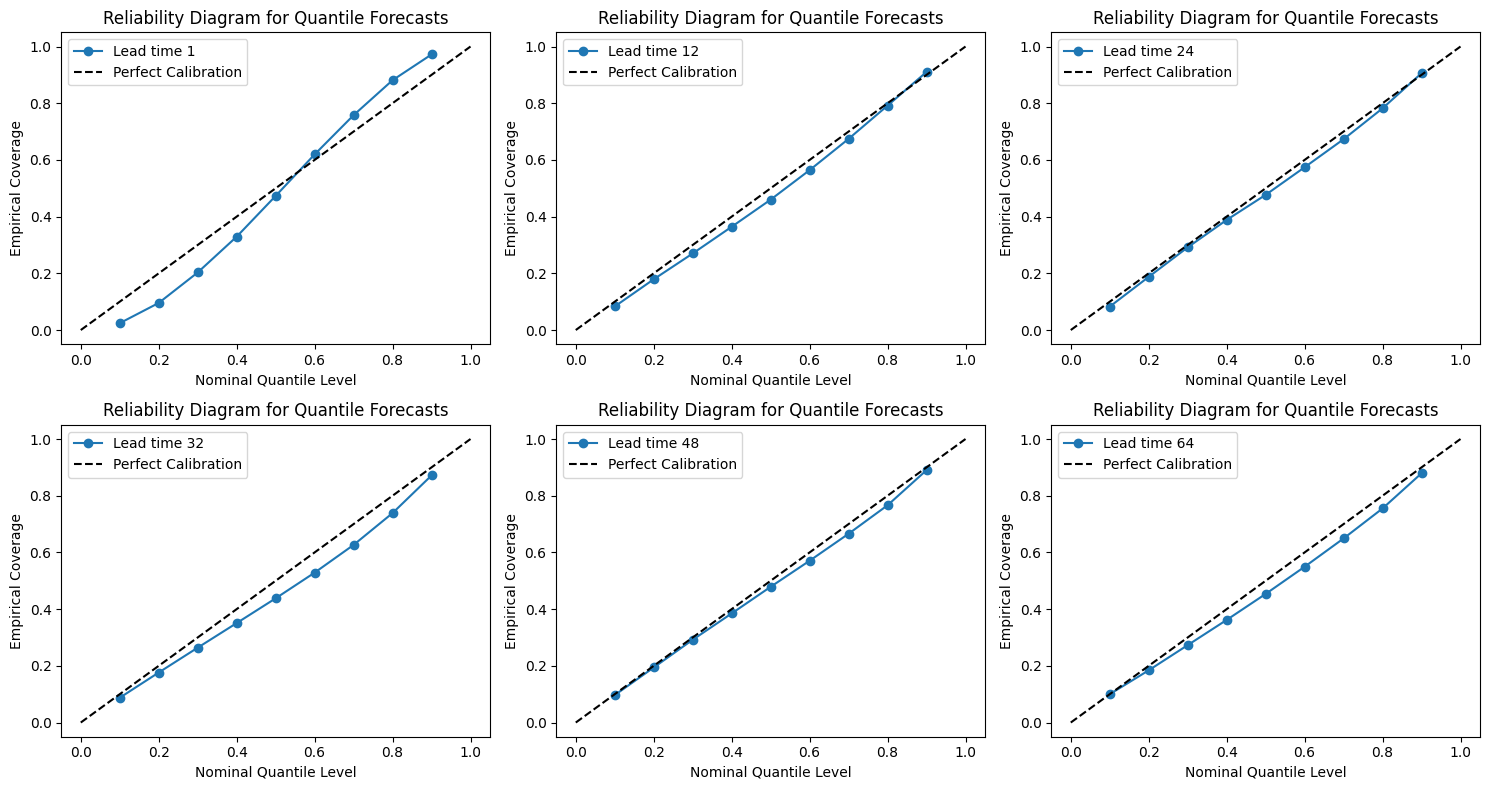

In [ ]:
# plot reliability diagrams
predictions.get_reliability_diagram([1, 12, 24, 32, 48, 64])

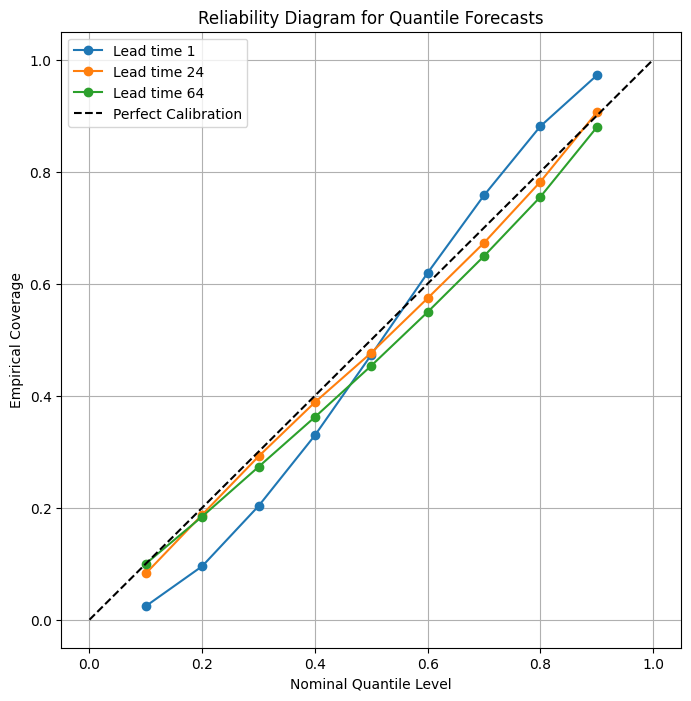

In [41]:
# use overlay
predictions.get_reliability_diagram([1, 24, 64], overlay=True)

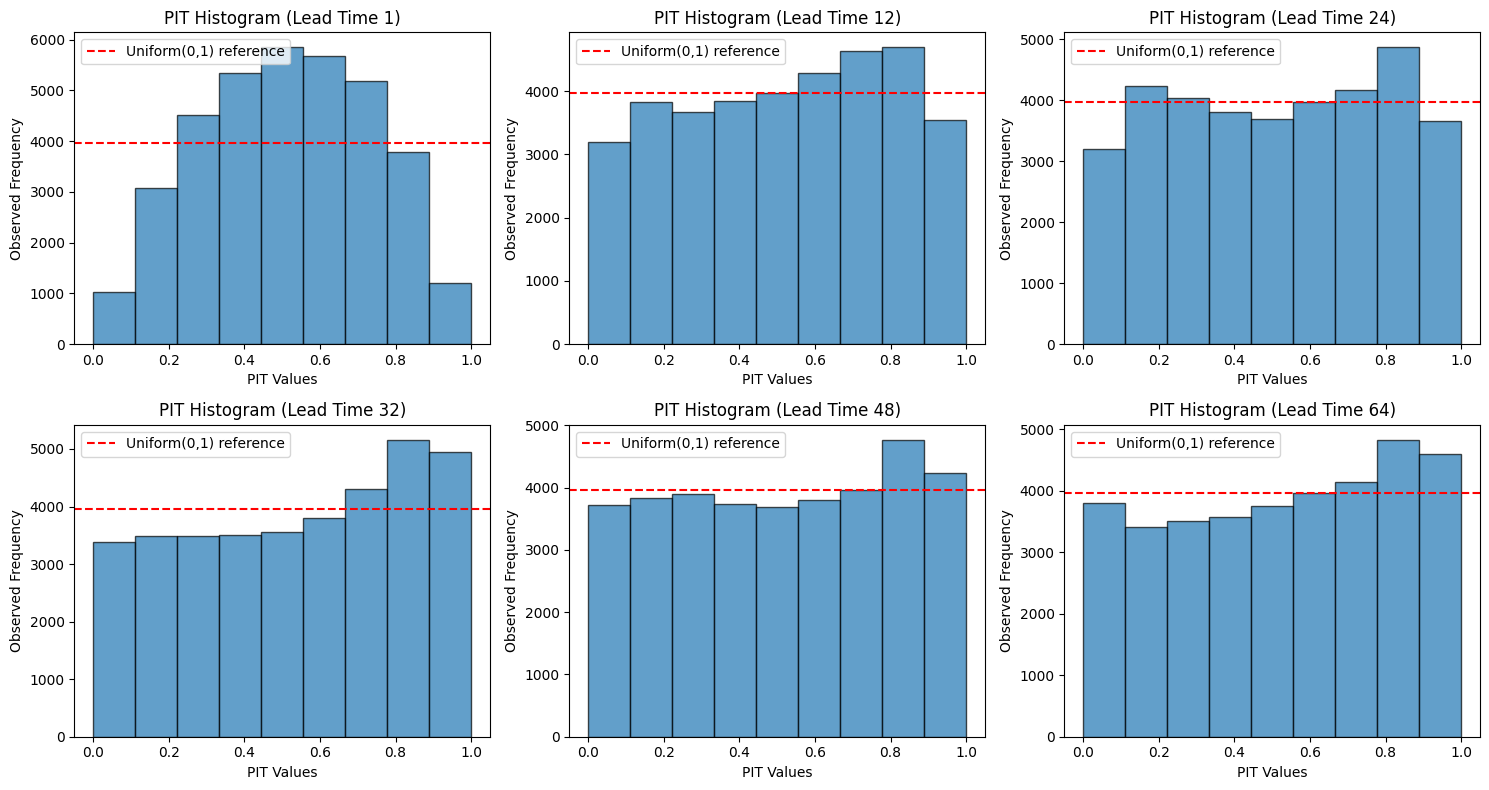

In [ ]:
# plot PIT histograms
predictions.get_pit_histogram([1, 12, 24, 32, 48, 64])